# Tone Analysis
Purpose: Determine the tone by looking at concreteness, valence, arousal, and dominance. This program is broken into two parts- one for combining the wordlists and the other for performing the calculation.

<br> Concreteness: measures tangibility 
<br> Valence: measures pleasantness 
<br> Arousal: measures intensity
<br> Dominance: measure degree of control


## Part I- Combining the wordlists

Some words in the concreteness wordlist are not in the valence, arousal, and dominance wordlist (and vice versa). For this tone analysis, we are only interested in words with all four dimensions.

In [1]:
#Imports
import pandas as pd
from functools import reduce
import numpy as np
from nltk.tokenize import word_tokenize
import json
import csv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
"""#Removing unncessary columns from concrete wordlist
df1 = pd.read_table('WordList_Concrete.csv', sep=',')
df1 = df1.drop(columns=['Bigram', 'Unknown','Total','SUBTLEX'])

#Removing unncessary columns from valence,arousal, dominance wordlist
df2 = pd.read_table('WordList_Valence_Arousal_Dominance.csv', sep=',')
df2 = df2.iloc[:, 0:11]
df2 = df2.drop(columns=['V.Rat.Sum', 'A.Rat.Sum','D.Rat.Sum'])

#Combining dataframes
dataFrame = [df1,df2]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Word'],
                                            how='outer'), dataFrame)
#Removing blank values and number column
df_merged = df_merged.replace('.', np.nan)
df_merged = df_merged.dropna()
df_merged = df_merged.drop(columns=['Unnamed: 0'])
pd.DataFrame.to_csv(df_merged, 'merged.csv', sep=',', na_rep='.', index=False)

#Creating a dictionary with the tone data for each word
dictionary = {}
redditData = pd.read_csv('merged.csv')
for index, row in redditData.iterrows():
    dictionary[row['Word']] = [row['Conc.M'],row['V.Mean.Sum'],row['A.Mean.Sum'],row['D.Mean.Sum']]

#writing results to a file
with open("dictionary.txt", "w") as outfile:
    json.dump(dictionary, outfile)"""

'#Removing unncessary columns from concrete wordlist\ndf1 = pd.read_table(\'WordList_Concrete.csv\', sep=\',\')\ndf1 = df1.drop(columns=[\'Bigram\', \'Unknown\',\'Total\',\'SUBTLEX\'])\n\n#Removing unncessary columns from valence,arousal, dominance wordlist\ndf2 = pd.read_table(\'WordList_Valence_Arousal_Dominance.csv\', sep=\',\')\ndf2 = df2.iloc[:, 0:11]\ndf2 = df2.drop(columns=[\'V.Rat.Sum\', \'A.Rat.Sum\',\'D.Rat.Sum\'])\n\n#Combining dataframes\ndataFrame = [df1,df2]\ndf_merged = reduce(lambda  left,right: pd.merge(left,right,on=[\'Word\'],\n                                            how=\'outer\'), dataFrame)\n#Removing blank values and number column\ndf_merged = df_merged.replace(\'.\', np.nan)\ndf_merged = df_merged.dropna()\ndf_merged = df_merged.drop(columns=[\'Unnamed: 0\'])\npd.DataFrame.to_csv(df_merged, \'merged.csv\', sep=\',\', na_rep=\'.\', index=False)\n\n#Creating a dictionary with the tone data for each word\ndictionary = {}\nredditData = pd.read_csv(\'merged.csv\'

In [3]:
#returns a dictionary from a file
def getDict(file):
    # reading the data from the file
    with open(file) as f:
        data = f.read()

     # closing the file
    f.close()

    # naming dictionary
    dict = json.loads(data)

    return dict

## Part II- Determining tone per post

Some words in the concreteness wordlist are not in the valence, arousal, and dominance wordlist (and vice versa). For this tone analysis, we are only interested in words with all four dimensions.

In [4]:
#stop words for filtering
stop_words = set(line.strip() for line in open('Stopwords.txt'))

In [5]:
#tokenizes post
def sentence_filter(redditData):
    word_tokens = word_tokenize(redditData)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []

    for word in redditData.lower().split():
        word = word.replace(".", "")
        word = word.replace(",", "")
        word = word.replace(":", "")
        word = word.replace("\"", "")
        word = word.replace("!", "")
        word = word.replace("â€œ", "")
        word = word.replace("â€˜", "")
        word = word.replace("*", "")
        word = word.replace("(", "")
        word = word.replace(")", "")
        word = word.replace("?", "")
        if word not in stop_words:
            filtered_sentence.append(word)
    return filtered_sentence

In [6]:
#returns vector of avg concrete, valence, arousal, and dominance for each post
def word_vector(filtered_sentence):
    d = 0
    c = 0
    a = 0
    v = 0
    count = 0
    for word in filtered_sentence:
        try:
            word_score = dictionary[word]
            # as a percentage
            c += word_score[0] / 5
            v += word_score[1] / 9
            a += word_score[2] / 9
            d += word_score[3] / 9
            count += 1
        except KeyError:
            count+=1
            continue

    #dividing by total words in post
    if d > 0:
        d = d / count
        a = a / count
        v = v / count
        c = c/ count
        return c,v,a,d

    else:
        return 0,0,0,0

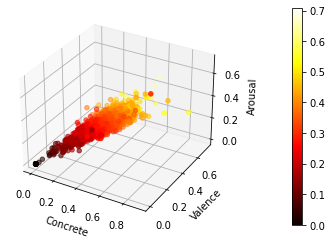

In [8]:
#Performing the analysis
dictionary = getDict("dictionary.txt")
concrete = []
valence = []
arousal = []
dominance = []
redditData = pd.read_csv('2018_posts_revised.csv')

#Determining score for each post
for i,row in redditData.iterrows():
    words = filter(row['selftext'])
    c,v,a,d = word_vector(words)
    concrete.append(c)
    valence.append(v)
    arousal.append(a)
    dominance.append(d)

redditData['concrete'] = concrete
redditData['valence'] = valence
redditData['arousal'] = arousal
redditData['dominance'] = dominance

#Creating csv with the additional data
redditData.to_csv('2018_posts_tone.csv')

#Plotting results
redditData = pd.read_csv('2018_posts_tone.csv')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Concrete')
ax.set_ylabel('Valence')
ax.set_zlabel('Arousal')
img=ax.scatter(redditData['concrete'],redditData['valence'],redditData['arousal'], c=redditData['dominance'], cmap=plt.hot())
fig.colorbar(img, pad=0.2)
plt.show()